# Setup a game

In [3]:
from ConnectN import ConnectN

# 3-by-3 board with winning condition as 3 wins in a row
game_setting = {'size':(3,3), 'N':3}
game = ConnectN(game_setting['size'], game_setting['N'])

In [5]:
# Make a move on [0,1]
game.move((0,1))

# Members
print(game.state) # Game board
print(game.player) # Player who has the next move
print(game.score) # None if game has not ended

[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
-1
None


In [6]:
# Making a couple of moves

# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))

print(game.state)
print(game.player)
print(game.score)

[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
1
1


# Play a game interactively

<IPython.core.display.Javascript object>


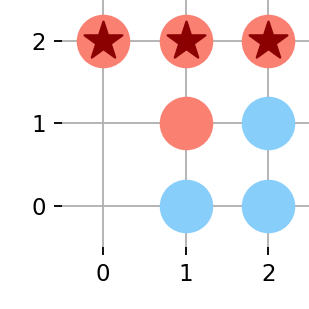

In [7]:
% matplotlib notebook

from Play import Play

# If players are none, then user is to play
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Initialize an AI to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

## Tentative Exercise:
Code up your own policy for training

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import *
import numpy as np
import random


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # Convolutional Layer
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        # 9 is output for num of actions
        self.fc_action2 = nn.Linear(16, 9) 
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        # 1 for the predicted return
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh() # Between -1 and 1

        
    def forward(self, x):
        
        #foward pass
        y = F.relu(self.conv(x))
        y = y.view(-1, self.size)
        y = F.relu(self.fc(y))
        
        
        # the action head
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)
        
        # availability of moves - map occupied spaces as prob of 0%
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.view(-1, 9)
        
        # locations where actions are not possible, we set the prob to zero
        maxa = torch.max(a)
        # subtract off max for numerical stability (avoids blowing up at infinity)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        
        return prob.view(3,3), value

In [13]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1.e-4, weight_decay=1.e-4)

## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

In [14]:
import MCTS

from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(50):
        # explore the tree
        '''
        Compute all the U values using policy , pick branch with max U, 
        search, expand, backpropagate...etc
        '''
        mytree.explore(policy)
    
    # temperature is an exploration rate
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    # Return the move played after incrementing tree
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    


In [15]:
game = ConnectN(**game_setting)
print(game.state)
Policy_Player_MCTS(game)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


(0, 2)

# Play a game against the policy

<IPython.core.display.Javascript object>


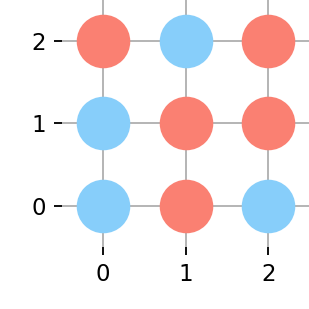

In [17]:
% matplotlib notebook


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


# Training Loop

In [31]:
# Initialize our alphazero agent and optimizer
import torch.optim as optim

game=ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1.e-4, weight_decay=1.e-4)

## Tenative exercise:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [32]:
# train our agent

from collections import deque
import MCTS

episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

##########################
#      Training Loop     #
##########################

for e in range(episodes):
    
    # Initialize the MC Tree with Game Settings
    mytree = MCTS.Node(ConnectN(**game_setting))
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        
        # Perform MCTS 50 Times
        for _ in range(50):
            mytree.explore(policy)

        current_player = mytree.game.player
        
        '''
        (v, nn_v, p, nn_p) are used to update policy
        
        v - expected outcome from tree search (not useful)
        nn_v - critic value
        p - probability from MCTS
        nn_p - probability w/o MCTS, just policy
        
        ''' 
        mytree, (v, nn_v, p, nn_p) = mytree.next()        
        mytree.detach_mother()
        
        # compute prob* log pi 
        loglist = torch.log(nn_p)*p
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))
        
        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    # Computing squared difference
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )

    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()

game:  50 , mean loss: 10.59 , recent outcomes:  [-1, 1, -1, 1, 1, -1, 1, 0, 1, 1]


game:  100 , mean loss: 9.62 , recent outcomes:  [0, 1, -1, 0, -1, 1, 0, 1, -1, -1]


game:  150 , mean loss: 9.00 , recent outcomes:  [1, 0, 1, 1, 1, 1, 0, 1, 1, 0]


game:  200 , mean loss: 8.68 , recent outcomes:  [-1, 1, -1, 1, -1, 1, 1, -1, 1, 1]


game:  250 , mean loss: 7.61 , recent outcomes:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1]


game:  300 , mean loss: 7.02 , recent outcomes:  [0, 0, 0, 0, -1, 1, 1, 1, 0, 0]


game:  350 , mean loss: 7.09 , recent outcomes:  [0, 1, 0, 1, 1, 1, 0, 0, 1, 1]


game:  400 , mean loss: 8.01 , recent outcomes:  [0, 0, 1, 1, 1, 0, -1, 0, 1, 0]


<IPython.core.display.Javascript object>


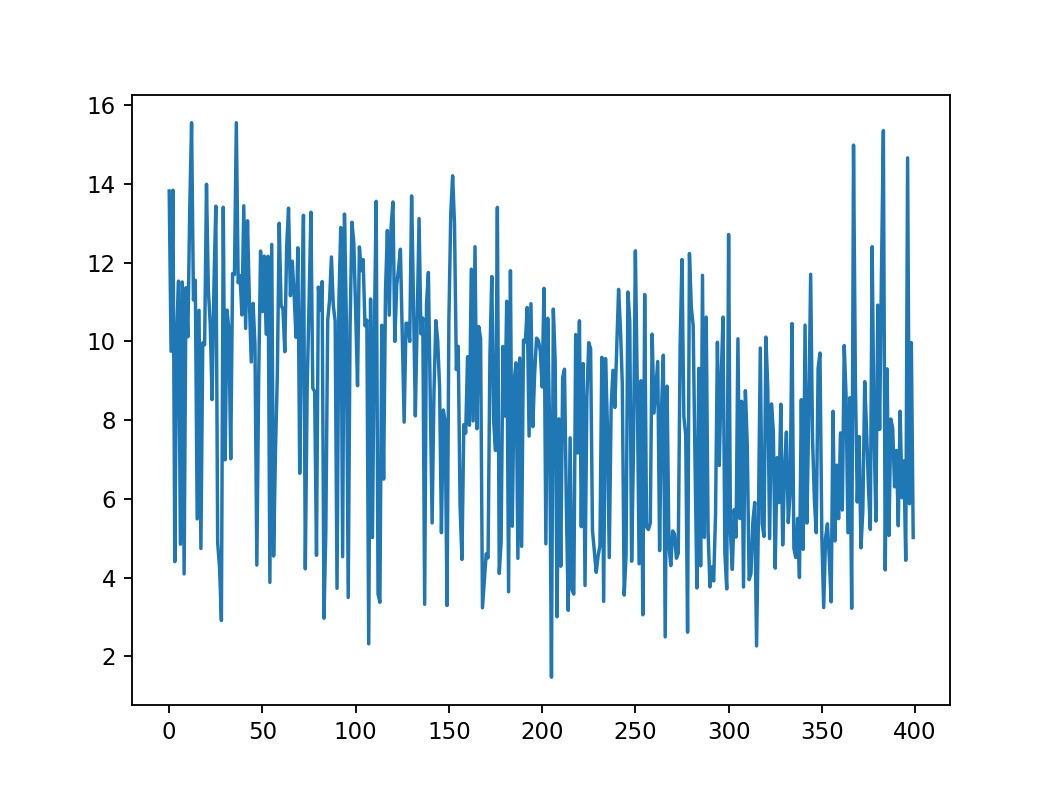

In [33]:
# plot your losses

import matplotlib.pyplot as plt

% matplotlib notebook
plt.plot(losses)
plt.show()


# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


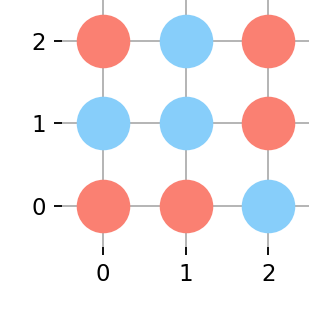

In [36]:
% matplotlib notebook

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


<IPython.core.display.Javascript object>


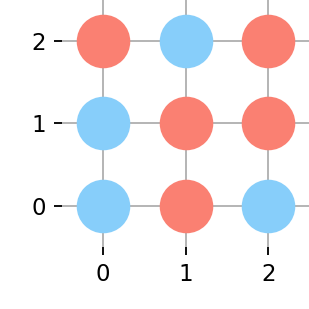

In [37]:
% matplotlib notebook

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)
